In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
#export
from exp.nb_10c import *

## Imagenet(te) training

In [2]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [3]:
size = 128
tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]

bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name = 'val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

ll.valid.x.tfms = [make_rgb, CenterCrop(size), np_to_float]

data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

## XResNet   
X stands for mutant/extended version

![resnet tweaks](images/resnet_tweaks.JPG)  
from the [Bag of Tricks for image classification paper](https://arxiv.org/abs/1812.01187)

We have already discusssed the Resnet-C tweak for the originial Resnet(left) above where using 3 3x3 convs leads to a better and faster result than a 7x7 conv with stride=2. Doing it the original way is super inefficient and it's just a single linear model which deosn't have that much richness to it. So we do the Resnet-C version where if you think about it, the receptive field of the final one is still gonna be 7x7 but its got there through a much richer set of features as we use 3x3 conv layers.  

####  In Resnet-D...
notice that you have an Avg pool and another conv layer on the right. Now THis is because if you're simply adding the identity block without any operation then you can not only change the no of channels on the left but also can't set the stride other than 1. Otherwise if wouldn't concatenate as they'd have different shapes. So what do we do? From time to time we add a conv layer w a stride=2 and double the no of channels at the same time and when do that we add to the identity path those two blocks. Avgpool layer causes the grid size to shift down by 2 in each dimension and 1x1 conv to double the no of channels. This approach gives you a nice little boost over the standard version.

#### In Resnet-B...
Notice that you do a stride 2 in the scond conv layer and not the first(like in traditional resnet). Doing the stride 2 on a 1x1 conv is a terrible idea because you're literally throwing away 3 quarters of the data(BIG OOF!). This took people years to actually realize how a stride2 on the first conv layer is wasting data.

In [4]:
#export
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)

In [5]:
#export
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
        
def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

The BatchNorm part of the code above is interesting because you initialize the weights to be zero if zero_bn=True is passed and 1 otherwise. Why do we do that?(Refer Resnet-D)
Looking at the Resblock function below, we see that after the last conv of each resblock we pass zero_bn=True thereby resulting in 0 as the output(everything gets multiplied by bn weights which is 0). SO now we're adding zero to the identity block; in other words the whole of resblock does nothing at all! Thats's a GREAT way to initialize a model. Because as we've seen, we don't want any layer to shift the mean and variance as we don't want our gradients to spiral off to zero/infinity. This way we ensure that our activations are literally the same all the way through. And thus we set the bn weight after the 3rd conv layer to be zero. This lets us train very deep models at very high learning rates. 
  
Jeremy exclaims that nearly all academic literature talks about large batch sizes because companies google and openAI like to show off their data centers. But for us normal people, this stuff is interesting as it tells us how high a L.R. can we go to. A higher lr enables you to train faster and genralize better.

In [6]:
#export
class ResBlock(nn.Module):
    # expansion=1 implies its a resnet18/34 and if expansion=4 then its bigger
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf, ni = nh*expansion, ni*expansion
        layers = [conv_layer(ni, nh, 3, stride=stride),### try ks=1
                  conv_layer(nh, nf, 3, zero_bn=True, act=False)
                  ] if expansion == 1 else [
                  conv_layer(ni, nh, 1),
                  conv_layer(nh, nh, 3, stride=stride),
                  conv_layer(nh, nf, 1, zero_bn=True, act=False)]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False) # if no of i/ps is different to the number of filters add a 1x1 conv layer
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # if stride is not 1 then add AvgPooling
        # when ceil_mode=True it uses ceil instead of floor to comput o/p shape
        
    def forward(self, x): return act_fn(self.convs(x)+ self.idconv(self.pool(x)))

The `(c_in+1)*8` as the number of filters in the second layer(see below) is interesting. If c_in=3 channels then the second layer contains 32 filters which is what the bag of tricks paper recommends. The *8 is there because Nvidia graphics cards like it when everything is in a multiple of 8(faster calculations probably). Also, if you tend to have a one channel input(b/w images) or a 5 channel input (in hyperspectral imaging) your second layer's filters are being dynamically changed.

In [7]:
#export
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64] # filters for the first three layers
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
                          for i in range(3)] # stem is the start of the CNN
        nfs = [64//expansion, 64, 128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                     n_blocks=1, stride=1 if i==0 else 2)
                     for i,l in enumerate(layers)]
        res = cls(
        *stem,
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        *res_layers,
        nn.AdaptiveAvgPool2d(1), Flatten(),
        nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res
    
    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
        *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
         for i in range(n_blocks)])

In [21]:
??init_cnn

Signature: init_cnn(m)
Docstring: <no docstring>
Source:   
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
File:      ~/tutorials/fastai/course-v3/nbs/dl2/<ipython-input-7-78129aa8e697>
Type:      function


In [8]:
#export
def xresnet18(**kwargs): return XResNet.create(1, [2,2,2,2], **kwargs)
def xresnet34(**kwargs): return XResNet.create(1, [3,4,6,3], **kwargs)
def xresnet50(**kwargs): return XResNet.create(4, [3,4,6,3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3,4,23,3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3,8,36,3], **kwargs)

Notice that for resnet18 and resnet34 each resblock has only 2 convs(Refer Resnet-D in image). In Resnet50 and above they squish the channels in the middle before increasing them so the layers would go like 64 filters, 16 and then 64 again. That's called as a bottleneck. The bottleneck block is the normal block for larger resnets. And 2 3x3 convs is the normal for smaller resnets.

## Train

In [9]:
cbfs = [partial(AvgStatsCallback, accuracy),
       ProgressCallback,
       CudaCallback,
       partial(BatchTransformXCallback, norm_imagenette)]#, 
#        partial(MixUp, 0.2)]

In [10]:
loss_func = LabelSmoothingCrossEntropy()
arch = partial(xresnet18, c_out=10)
opt_func = adam_opt(mom=0.9, mom_sqr = 0.99, eps = 1e-6, wd = 1e-2)

In [11]:
#export
def get_batch(dl, learn):
    learn.xb, learn.yb = next(iter(dl))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb, learn.yb

We need to replace the old `model_summary` since it use to take a `Runner` class

In [12]:
#export
def model_summary(learn, data, find_all=False, print_mod=False):
    xb,yb = get_batch(data.valid_dl, learn)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook,mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
    with Hooks(mods, f) as hooks: learn.model(xb)

In [13]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [14]:
learn.model = learn.model.cuda()
model_summary(learn.model, data, print_mod=False)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


 torch.Size([128, 32, 64, 64])


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 15.90 GiB total capacity; 170.95 MiB already allocated; 119.88 MiB free; 176.00 MiB reserved in total by PyTorch)

In [37]:
model_summary(learn.model, data, print_mod=True)
# learn.model

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


====
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
 torch.Size([128, 32, 64, 64])
====
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
 torch.Size([128, 64, 64, 64])
====
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
 torch.Size([128, 64, 64, 64])
====
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 torch.Size([128, 64, 32, 32])
====
Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [38]:
arch = partial(xresnet34, c_out=10)

In [40]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [41]:
learn.fit(1, cbs=[LR_Find(), Recorder()])

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


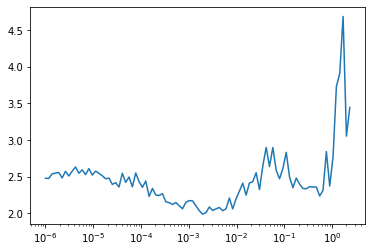

In [43]:
learn.recorder.plot(100)

In [46]:
#export
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]


In [47]:
print(create_phases(0.3))
print(create_phases([0.3,0.2]))

[0.3, 0.7]
[0.3, 0.2, 0.5]


In [51]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [52]:
cbsched = [
    ParamScheduler('lr', sched_lr),
    ParamScheduler('mom', sched_mom)
]

In [60]:
lr

0.01

without mixup:

In [63]:
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [65]:
learn.fit(10, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.746758,0.464463,1.638353,0.522803,00:08
1,1.490771,0.591826,2.177079,0.417070,00:08
2,1.412634,0.623931,1.803087,0.522038,00:08
3,1.314527,0.666068,2.233624,0.436688,00:08
4,1.242664,0.700496,1.431040,0.608917,00:08
5,1.164159,0.732601,1.861082,0.512866,00:08
6,1.079400,0.772943,1.242159,0.688662,00:08
7,0.991685,0.809800,1.026632,0.789554,00:08
8,0.907677,0.848030,0.906899,0.844331,00:08
9,0.855432,0.867040,0.897980,0.849172,00:08


with MixUP:

In [68]:
cbfs = [partial(AvgStatsCallback, accuracy),
       ProgressCallback,
       CudaCallback,
       partial(BatchTransformXCallback, norm_imagenette), 
       partial(MixUp, 0.2)]

learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)
learn.fit(10, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.921048,0.425494,1.761690,0.449936,00:08
1,1.727974,0.539022,1.511050,0.583439,00:08
2,1.670630,0.575140,1.772466,0.505987,00:08
3,1.587605,0.624353,1.683639,0.527134,00:08
4,1.540150,0.643046,1.438438,0.607388,00:08
5,1.463773,0.684866,1.349475,0.628025,00:08
6,1.392837,0.726370,1.095694,0.773758,00:08
7,1.330963,0.757841,1.016804,0.795669,00:08
8,1.259930,0.794487,0.941027,0.834395,00:08
9,1.221179,0.818566,0.923729,0.842293,00:08


## cnn_learner  
Refactoring it a bit.

In [78]:
#export
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None, lr=1e-2,
               cuda=True, norm=None, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback, accuracy)] + listify(xtra_cb)
    if progress: cbfs.append(ProgressCallback)
    if cuda: cbfs.append(CudaCallback)
    if norm: cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup: cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in: c_in = data.c_in
    if not c_out: c_out = data.c_out
    if c_in: arch_args['c_in'] = c_in
    if c_out: arch_args['c_out'] = c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)        

In [79]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func, norm=norm_imagenette)

In [80]:
learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.752833,0.464674,1.982242,0.427771,00:09
1,1.551207,0.563101,2.093762,0.433631,00:08
2,1.417543,0.615799,1.775300,0.511847,00:08
3,1.224483,0.701658,1.145202,0.745478,00:08
4,1.066336,0.774739,1.040329,0.782420,00:08


## Imagenet

You can see all this put together in the fastai [imagenet training script](https://github.com/fastai/fastai/blob/master/examples/train_imagenet.py). It's the same as what we've seen so far, except it also handles multi-GPU training. So how well does this work?

We trained for 60 epochs, and got an error of 5.9%, compared to the official PyTorch resnet which gets 7.5% error in 90 epochs! Our xresnet 50 training even surpasses standard resnet 152, which trains for 50% more epochs and has 3x as many layers.

## Export

In [ ]:
!./notebook2script.py 11_train_imagenette.ipynb

Converted 11_train_imagenette.ipynb to exp/nb_11.py
